# Density-adjusted group connection test

In [1]:

import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pkg.data import load_network_palette, load_unmatched
from pkg.io import FIG_PATH, OUT_PATH, get_environment_variables
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.perturb import remove_edges
from pkg.plot import (
    SmartSVG,
    draw_hypothesis_box,
    heatmap_grouped,
    networkplot_simple,
    plot_pvalues,
    set_theme,
    svg_to_pdf,
)
from pkg.stats import compute_density, stochastic_block_test
from svgutils.compose import Figure, Panel, Text
from tqdm.autonotebook import tqdm

from giskard.plot import merge_axes
from graspologic.simulations import sbm

_, RERUN_SIMS, DISPLAY_FIGS = get_environment_variables()

FILENAME = "adjusted_sbm_unmatched_test"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "celltype_discrete"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

Environment variables:
   RESAVE_DATA: True
   RERUN_SIMS: False
   DISPLAY_FIGS: False



In [2]:

set_theme()
np.random.seed(888888)
ns = [5, 6, 7]
B = np.array([[0.8, 0.2, 0.05], [0.05, 0.9, 0.2], [0.05, 0.05, 0.7]])
A1, labels = sbm(ns, B, directed=True, loops=False, return_labels=True)

node_data = pd.DataFrame(index=np.arange(A1.shape[0]))
node_data["labels"] = labels + 1
palette = dict(zip(np.unique(labels) + 1, sns.color_palette("Set2")[3:]))


fig, axs = plt.subplots(
    2,
    2,
    figsize=(6, 5),
    gridspec_kw=dict(wspace=0.25, hspace=0, height_ratios=[2, 0.3]),
)


ytop = 1.05
ybottom = 0.11
xleft = 0.05
xright = 0.68
border_color = "lightgrey"
line1 = mpl.lines.Line2D(
    (0.15, 0.95),
    (0.4, 0.4),
    transform=fig.transFigure,
    color=border_color,
    linewidth=1.5,
)


ax = axs[0, 0]
_, _, misc = stochastic_block_test(A1, A1, node_data["labels"], node_data["labels"])
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(r"$\hat{B}^{(R)}$", color=network_palette["Right"], size="large")
ax.set_title(
    "Scale connection probabilities\nto match densities",
    fontsize="medium",
    x=1.1,
    y=1.3,
)

ax = axs[0, 1]
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(0.6 * Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(
    r"$\hat{B}^{(R)}$", color=network_palette["Right"], x=0.55, size="large"
)
top_ax.text(0.94, -1.2, r"$c$", size="large")

ax.annotate(
    "",
    xy=(0, 1.5),
    xytext=(-0.9, 1.5),
    arrowprops=dict(
        arrowstyle="simple",
        shrinkA=5,
        shrinkB=10,
        facecolor="black",
    ),
    zorder=1,
    clip_on=False,
)


ax = merge_axes(fig, axs, rows=1)
ax.axis("off")
ax.set(xlim=(0, 1), ylim=(0, 2))

draw_hypothesis_box("dasbm", 0.27, 2, ax=ax, yskip=1.2, ypad=0.03)

fig.set_facecolor("w")

gluefig("adjusted_methods_explain", fig)

In [3]:

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

node_data = networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)

n_select = 10
row_inds, col_inds = np.nonzero(A1)
np.random.seed(8888)
choice_inds = np.random.choice(len(row_inds), size=n_select)
for i in choice_inds:
    source_node = row_inds[i]
    target_node = col_inds[i]
    x1, y1 = node_data.loc[source_node, ["x", "y"]]
    x2, y2 = node_data.loc[target_node, ["x", "y"]]
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    ax.text(
        x,
        y,
        "x",
        va="center",
        ha="center",
        color="darkred",
        fontsize="medium",
        zorder=2,
    )


ax.set_title("Remove edges to\n match density (random)", fontsize="medium")
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

fig.set_facecolor("white")
gluefig("edge_removal_methods", fig)

In [4]:
n_edges_left = np.count_nonzero(left_adj)
n_edges_right = np.count_nonzero(right_adj)
n_left = left_adj.shape[0]
n_right = right_adj.shape[0]
density_left = n_edges_left / (n_left**2)
density_right = n_edges_right / (n_right**2)

# TODO double check this
n_remove = (density_right - density_left) * (n_right**2)
print("n_remove", n_remove)
n_remove = int(np.round(n_remove))
print("n_remove", n_remove)

glue("n_remove", n_remove)

n_remove 2759.999999999997
n_remove 2760


In [5]:
# test

subsampled_right_adj = remove_edges(right_adj, effect_size=n_remove, random_seed=rng)

new_right_density = compute_density(subsampled_right_adj)

print("density left", density_left)
print("density right", density_right)
print("density right (subsampled)", new_right_density)

density left 0.01609321897888746
density right 0.017310130879756757
density right (subsampled) 0.016103912147644197


In [6]:
# NOTE: not running this right now as this figure is no longer in the final paper

rows = []
n_resamples = 500
glue("n_resamples", n_resamples)

if RERUN_SIMS:
    for i in tqdm(range(n_resamples)):
        subsampled_right_adj = remove_edges(
            right_adj, effect_size=n_remove, random_seed=rng
        )
        for method in ["fisher", "score"]:
            stat, pvalue, misc = stochastic_block_test(
                left_adj,
                subsampled_right_adj,
                labels1=left_labels,
                labels2=right_labels,
                method=method,
            )
            rows.append(
                {
                    "stat": stat,
                    "pvalue": pvalue,
                    "misc": misc,
                    "resample": i,
                    "method": method,
                }
            )
    resample_results = pd.DataFrame(rows)
    resample_results.to_csv(OUT_PATH / "resample_results.csv")
else:
    resample_results = pd.read_csv(OUT_PATH / "resample_results.csv", index_col=0)

In [7]:

left_density = compute_density(left_adj)
right_density = compute_density(right_adj)
c = left_density / right_density
glue("c", c, form="0.2f")

stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
    density_adjustment=True,
)
glue("pvalue", pvalue, form="pvalue")
print("pvalue", pvalue)


fig, axs = plot_pvalues(misc)

gluefig("sbm_pvalues", fig)

fig, axs = plot_pvalues(misc, annot_missing=False)

gluefig("sbm_pvalues_unlabeled", fig)

pvalue 0.0046509184480731805


In [8]:

set_theme(font_scale=1.25)

palette = dict(zip(["fisher", "score"], sns.color_palette(n_colors=2)))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=resample_results,
    x="pvalue",
    ax=ax,
    # color=neutral_color,
    hue="method",
    kde=True,
    log_scale=True,
    stat="density",
    bins=15,
    palette=palette,
)
sns.move_legend(ax, "upper left", title="Method")
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().capitalize())

for method in ["fisher", "score"]:
    median = np.median(resample_results.query(f"method == '{method}'")["pvalue"])
    ax.axvline(median, linestyle="-", color=palette[method], linewidth=3)

ax.set(xlabel="p-value", ylabel="", yticks=[])

# draw line for alpha
ax.spines["left"].set_visible(False)
ax.axvline(0.05, linestyle=":", color="black", linewidth=3)
ylim = ax.get_ylim()
ax.text(0.06, ylim[1] * 0.9, r"$\alpha = 0.05$")


color = "darkred"
ax.axvline(pvalue, color=color, linewidth=3, linestyle="--")
# ax.text(
#     pvalue - 0.0005,
#     ylim[1] * 0.85,
#     f"Analytic = {pvalue:0.2g}",
#     ha="right",
#     color=color,
# )

gluefig("resampled_pvalues_distribution", fig)

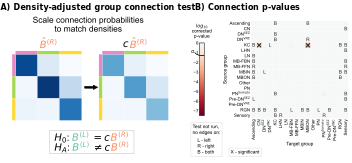

In [9]:


fontsize = 8

methods = SmartSVG(FIG_PATH / "adjusted_methods_explain.svg")
methods.set_width(200)
methods.move(10, 15)
methods_panel = Panel(
    methods,
    Text(
        "A) Density-adjusted group connection test",
        0,
        10,
        size=fontsize,
        weight="bold",
    ),
)


pvalues = SmartSVG(FIG_PATH / "sbm_pvalues.svg")
pvalues.set_width(200)
pvalues.move(0, 20)
pvalues_panel = Panel(
    pvalues,
    Text("B) Connection p-values", 5, 10, size=fontsize, weight="bold"),
)
pvalues_panel.move(methods.width * 0.95, 0)

fig = Figure(
    (methods.width + pvalues.width) * 0.88,
    (pvalues.height) * 0.95,
    methods_panel,
    pvalues_panel,
)
fig.save(FIG_PATH / "adjusted_sbm_composite.svg")

svg_to_pdf(
    FIG_PATH / "adjusted_sbm_composite.svg",
    FIG_PATH / "adjusted_sbm_composite.pdf",
)

fig

# #%%
# methods = SmartSVG(FIG_PATH / "edge_removal_methods.svg")
# methods.set_width(200)
# methods.move(5, 15)
# methods_panel = Panel(
#     methods,
#     Text(
#         "A) Random edge removal methods",
#         0,
#         10,
#         size=fontsize,
#         weight="bold",
#     ),
# )

# distribution = SmartSVG(FIG_PATH / "resampled_pvalues_distribution.svg")
# distribution.set_width(200)
# distribution.move(10, 15)
# distribution_panel = Panel(
#     distribution,
#     Text(
#         "B) Distribution of p-values from subsamples",
#         5,
#         10,
#         size=fontsize,
#         weight="bold",
#     ),
# )
# distribution_panel.move(methods.width * 0.9, 0)

# fig = Figure(
#     (methods.width + distribution.width) * 0.9,
#     (distribution.height) * 0.9,
#     methods_panel,
#     distribution_panel,
# )
# fig.save(FIG_PATH / "adjusted_sbm_random_composite.svg")

# svg_to_pdf(
#     FIG_PATH / "adjusted_sbm_random_composite.svg",
#     FIG_PATH / "adjusted_sbm_random_composite.pdf",
# )

# fig

## End

In [10]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:11.024195
Completed at 2023-03-08 12:41:12.410188
